In [1]:

from dataclasses import dataclass, field
from typing import Optional

import clingo
import networkx as nx
from clingox.program import Program, ProgramObserver


In [3]:
reasoning = """

#program derived.

pos(V) :- walk((_,V)).

cost(C + W) :- C = @prev_cost(), walk(E), W = @weight(E).
tour :- pos(1).
complete :- walk(E), @visited_all(E) = true.

#program choice.

1 { walk(E) : E = @edges(V), V = @pos() } 1.

#program goal.

goal :- tour, complete.

"""

In [4]:
@dataclass
class SearchNode:
    position: int = 1
    visited: frozenset = field(default_factory=frozenset)
    p_cost: int = 0

    def create_context(self, graph):
        return GraphContext(graph=graph, visited=self.visited, p_cost=self.p_cost, position=self.position)

    def __hash__(self):
        return hash(('SearchNode', self.position, self.visited, self.p_cost))

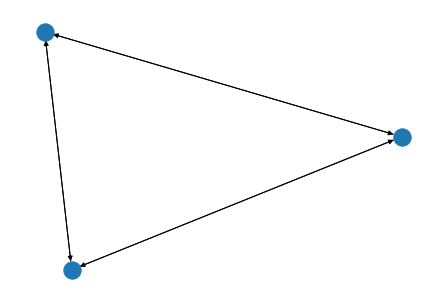

In [5]:
graph = nx.DiGraph()
graph.add_weighted_edges_from(
    [(1, 2, 10),
     (1, 3, 100),
     (2, 1, 100),
     (2, 3, 10),
     (3, 1, 10),
     (3, 2, 100)],
)
nx.draw(graph)

In [6]:
graph.edges(data=True)

OutEdgeDataView([(1, 2, {'weight': 10}), (1, 3, {'weight': 100}), (2, 1, {'weight': 100}), (2, 3, {'weight': 10}), (3, 1, {'weight': 10}), (3, 2, {'weight': 100})])

In [7]:
@dataclass
class GraphContext:
    graph: nx.DiGraph
    p_cost: int = 0
    visited: frozenset = field(default_factory=frozenset)
    position: int = 1

    @staticmethod
    def get_edge(edge: clingo.Symbol, graph: Optional[nx.Graph] = None):
        outgoing_node = edge.arguments[0].number
        incoming_node = edge.arguments[1].number
        weight = None
        if graph is not None:
            weight = graph[outgoing_node][incoming_node]['weight']
        return outgoing_node, incoming_node, weight

    def prev_cost(self):
        return clingo.Number(self.p_cost)

    def weight(self, edge: clingo.Symbol):
        _, _, weight = GraphContext.get_edge(edge, self.graph)
        return clingo.Number(weight)

    def visited_all(self, edge: clingo.Symbol):
        if len(self.visited) + 1 < len(self.graph.edges) // 2:
            return clingo.Function("false")
        outgoing_node, incoming_node, _ = GraphContext.get_edge(edge)
        visited_edges = set(map(tuple, map(sorted, self.visited)))
        visited_edges.add(tuple(sorted((outgoing_node,incoming_node))))
        all_edges = set(map(tuple, map(sorted, self.graph.edges)))
        print(visited_edges, all_edges)
        if visited_edges == all_edges:
            return clingo.Function("true")
        return clingo.Function("false")

    def edges(self, vertex: clingo.Symbol):
        v = vertex.number
        ns = self.graph.successors(v)
        return [clingo.Tuple_((vertex, clingo.Number(n))) for n in ns]

    def pos(self):
        return clingo.Number(self.position)


In [8]:
graph.edges(data=True)
for edge in graph.edges(data=True):
    print("({},{}):".format(edge[0], edge[1]), edge[-1]['weight'])

(1,2): 10
(1,3): 100
(2,1): 100
(2,3): 10
(3,1): 10
(3,2): 100


In [9]:
fringe = []
closed = set()
root = SearchNode()
fringe.append(root)
best_solution = (None, 1 + sum(edge[-1]['weight'] for edge in graph.edges(data=True)))
explored = 0
print("Starting search:")
print("Fringe:", fringe)
print("Best solution:", best_solution)

Starting search:
Fringe: [SearchNode(position=1, visited=frozenset(), p_cost=0)]
Best solution: (None, 331)


In [29]:
if not fringe:
    print("Found best solution:", best_solution)
else:
    explored += 1
    node = fringe.pop()
    closed.add(node)
    print(node)
    if node.p_cost <= best_solution[1]:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0


        prg = Program()
        obs = ProgramObserver(prg)
        ctl.register_observer(obs)

        ctl.add("base", (), reasoning)
        ctx = node.create_context(graph)
        ctl.ground([("base", []), ("choice", []), ("derived", []), ("goal", [])], context=ctx)

        print("Facts:", len(prg.facts), "Rules:", len(prg.rules))
        print("-"*20)
        print(prg)
        print("-"*20)

        children = []
        with ctl.solve(yield_=True) as solve_handle:
            for model in solve_handle:
                position = None
                visited = set(node.visited)
                p_cost = None
                goal = False
                atoms = model.symbols(atoms=True)
                print('{', ' '.join(map(str, sorted(atoms))), '}')
                for atom in atoms:
                    if atom.match('pos', 1):
                        position = atom.arguments[0].number
                    elif atom.match('walk', 1):
                        edge = atom.arguments[0]
                        outgoing_node, incoming_node, _ = GraphContext.get_edge(edge)
                        visited.add((outgoing_node, incoming_node))
                    elif atom.match('cost', 1):
                        p_cost = atom.arguments[0].number
                    elif atom.match('goal', 0):
                        goal = True
                if goal:
                    print("Found solution")
                    prev_best, prev_best_cost = best_solution
                    if prev_best_cost > p_cost:
                        best_solution = explored, p_cost
                        print("New best solution")
                else:
                    child = SearchNode(position, frozenset(visited), p_cost)
                    if child not in closed:
                        children.append(child)
        #children.sort(key=lambda c: c.p_cost,reverse=True)
        fringe.extend(children)
    else:
        print("Remove node.", "Current best:", best_solution[1])
fringe

Found best solution: (16, 30)


[]

In [11]:
explored

1